<a href="https://colab.research.google.com/github/jhyn1687/colab/blob/main/Cats_vs_Dogs_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning on Kaggle Competition: Cats vs Dogs

We're doing some **transfer learning** by fine tuning a similar model with the pretrained weights on a different dataset (https://www.kaggle.com/c/dog-vs-cat-classification/data).

## Downloading Kaggle Competition Data

### Making sure we're on the right API version

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=9a6dc40ab450dd84f569d85b47ee85a39e61cc41481ff5f79634cd01d1d1893e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


### Co-lab API setup

https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


### Downloading Data and Unzipping

In [ ]:
!kaggle competitions download -c dog-vs-cat-classification

 99% 708M/718M [00:06<00:00, 117MB/s]
100% 718M/718M [00:06<00:00, 117MB/s]


In [ ]:
!unzip dog-vs-cat-classification.zip -d dog-vs-cat-classification

Streaming output truncated to the last 5000 lines.
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5499.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.55.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.550.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5500.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5501.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5502.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5503.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5504.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5505.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5506.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5507.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5508.jpg  
  inflating: dog-vs-cat-classification/train/train/dogs/dog.5509.jpg  
  inflating: dog-vs-cat-class

In [ ]:
!ls dog-vs-cat-classification/test/test

000000.jpg  001334.jpg	002668.jpg  004002.jpg	005336.jpg  006670.jpg
000001.jpg  001335.jpg	002669.jpg  004003.jpg	005337.jpg  006671.jpg
000002.jpg  001336.jpg	002670.jpg  004004.jpg	005338.jpg  006672.jpg
000003.jpg  001337.jpg	002671.jpg  004005.jpg	005339.jpg  006673.jpg
000004.jpg  001338.jpg	002672.jpg  004006.jpg	005340.jpg  006674.jpg
000005.jpg  001339.jpg	002673.jpg  004007.jpg	005341.jpg  006675.jpg
000006.jpg  001340.jpg	002674.jpg  004008.jpg	005342.jpg  006676.jpg
000007.jpg  001341.jpg	002675.jpg  004009.jpg	005343.jpg  006677.jpg
000008.jpg  001342.jpg	002676.jpg  004010.jpg	005344.jpg  006678.jpg
000009.jpg  001343.jpg	002677.jpg  004011.jpg	005345.jpg  006679.jpg
000010.jpg  001344.jpg	002678.jpg  004012.jpg	005346.jpg  006680.jpg
000011.jpg  001345.jpg	002679.jpg  004013.jpg	005347.jpg  006681.jpg
000012.jpg  001346.jpg	002680.jpg  004014.jpg	005348.jpg  006682.jpg
000013.jpg  001347.jpg	002681.jpg  004015.jpg	005349.jpg  006683.jpg
000014.jpg  001348.jpg	002682.jpg 

## Setup 

We're going to modify Using transfer learning code from Tutorial 3, 

### Imports

In [ ]:
import torch
import os 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#from tensorflow.keras import layers


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Training function

The training function is similar to past versions with some updates. In particular, now there is a `schedule` parameter to handle learning rate scheduling and also a `checkpoint_path` parameter which will be where training checkpoints are saved (if provided).

The core of training is the same though, get a batch, run the model forward, calculate loss, run it backward, update.

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.eval()

  result_array, image_paths = np.array([]), np.array([])
 
  with torch.no_grad():
      for i, (image, image_path) in enumerate(dataloader):
          test_input = image.to(device)
          outputs = net(test_input)
          _, predicted = torch.max(outputs, 1)
          result_array = np.append(result_array, predicted.cpu().detach().numpy())
          image_paths = np.append(image_paths, image_path)
  
  return {'results': result_array, 'image_paths': image_paths}

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Loading Data into Python

In [ ]:
!ls

dog-vs-cat-classification  dog-vs-cat-classification.zip  sample_data


### custom dataloader for testing samples
https://www.kaggle.com/khoatran1312/dog-cat-classification

In [ ]:
class TestingDataset(Dataset):
    
    def __init__(self, root, transforms=None):
        self.transforms = transforms
        self.img_paths = sorted(os.path.join(root, x) for x in os.listdir(root) if x.endswith('.jpg'))

        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = default_loader(img_path)
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample, img_path.split('/')[-1]

In [ ]:
def get_kaggle_data(augmentation=0):
  # Data augmentation transformations. Not for Testing!
  if augmentation:
    transform_train = transforms.Compose([
      transforms.Resize((256,256)),
      transforms.RandomCrop(224, padding=16, padding_mode='edge'),
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([                               
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
  ])

  data_dir = '/content/dog-vs-cat-classification'

  #trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        #transform=transform_train)
  
  trainset = torchvision.datasets.ImageFolder(data_dir + '/train/train', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=125, shuffle=True,
                                            num_workers=2)

  #testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                      #transform=transform_test)

  #testset = torchvision.datasets.ImageFolder(data_dir + '/test/test', transform=transform_test)
  testset = TestingDataset(data_dir + '/test/test', transforms=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=125, shuffle=False,
                                          num_workers=2)
  classes = ['cat', 'dog']
  return {'train': trainloader, 'test': testloader, 'classes': classes}

kaggle_data = get_kaggle_data(augmentation=1)
!ls

dog-vs-cat-classification  dog-vs-cat-classification.zip  sample_data


In [ ]:
!ls

dog-vs-cat-classification  dog-vs-cat-classification.zip  sample_data


### Visualize data

just checking if the pictures even show up lol


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


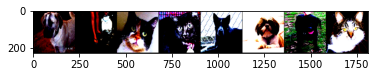

Labels:tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0)
torch.Size([8, 3, 224, 224])
torch.Size([8, 150528])


In [ ]:
dataiter = iter(kaggle_data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

## Let's do some DarkNet


In [ ]:
class Darknet64Kaggle(nn.Module):
    def __init__(self):
        super(Darknet64Kaggle, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc10 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc10(x)
        return x

In [ ]:
darknet = Darknet64Kaggle()
darknet_losses = train(darknet, kaggle_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
plt.plot(smooth(darknet_losses,50))

### Darknet with more Epochs?

Learning rate: 0.010000
[0,   100] loss: 0.620
[0,   200] loss: 0.555
[1,   100] loss: 0.514
[1,   200] loss: 0.512
[2,   100] loss: 0.474
[2,   200] loss: 0.475
[3,   100] loss: 0.428
[3,   200] loss: 0.410
[4,   100] loss: 0.403
[4,   200] loss: 0.388
[5,   100] loss: 0.358
[5,   200] loss: 0.350
[6,   100] loss: 0.338
[6,   200] loss: 0.331
[7,   100] loss: 0.310
[7,   200] loss: 0.302
[8,   100] loss: 0.270
[8,   200] loss: 0.260
[9,   100] loss: 0.257
[9,   200] loss: 0.247
Learning rate: 0.001000
[10,   100] loss: 0.205
[10,   200] loss: 0.192
[11,   100] loss: 0.188
[11,   200] loss: 0.187
[12,   100] loss: 0.186
[12,   200] loss: 0.177
[13,   100] loss: 0.181
[13,   200] loss: 0.180
[14,   100] loss: 0.180
[14,   200] loss: 0.176
[15,   100] loss: 0.167
[15,   200] loss: 0.179
[16,   100] loss: 0.175
[16,   200] loss: 0.171
[17,   100] loss: 0.176
[17,   200] loss: 0.170
[18,   100] loss: 0.169
[18,   200] loss: 0.165
[19,   100] loss: 0.166
[19,   200] loss: 0.165
Learning rat

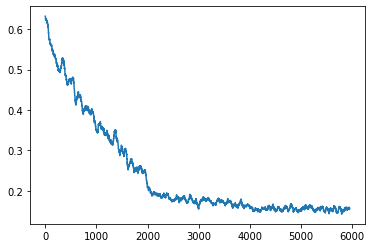

In [ ]:
darknet_30 = Darknet64Kaggle()
darknet_30_losses = train(darknet_30, kaggle_data['train'], epochs=30, schedule={0:.01, 10:.001, 20:.0001}, print_every=100)
plt.plot(smooth(darknet_30_losses,50))

## What about ResNet?
Using pretrained models from PyTorch, we will try 2 different models to see which one is the best at classifying Cats vs Dogs.




### ResNet18
First, we will load the resnet18 model that's pretrained from PyTorch.

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[0,   100] loss: 0.078
[0,   200] loss: 0.046
[1,   100] loss: 0.034
[1,   200] loss: 0.028
[2,   100] loss: 0.018
[2,   200] loss: 0.018
[3,   100] loss: 0.014
[3,   200] loss: 0.014
[4,   100] loss: 0.012
[4,   200] loss: 0.011


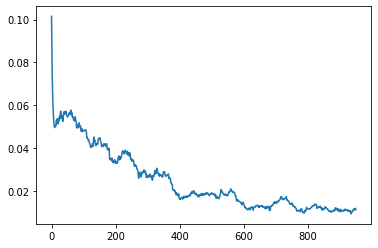

In [ ]:
kaggle_data = get_kaggle_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# Before
# resnet.fc = nn.Linear(512, 1000)
resnet.fc = nn.Linear(512, 2) # Reinitializes final layer, assigns random weights

resnet_losses = train(resnet, kaggle_data['train'], epochs=5, lr=.01, print_every=100)
plt.plot(smooth(resnet_losses,50))

### ResNet18-SWSL

https://pytorch.org/hub/facebookresearch_semi-supervised-ImageNet1K-models_resnext/

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


[0,   100] loss: 0.087
[0,   200] loss: 0.062
[1,   100] loss: 0.038
[1,   200] loss: 0.040
[2,   100] loss: 0.028
[2,   200] loss: 0.030
[3,   100] loss: 0.028
[3,   200] loss: 0.021
[4,   100] loss: 0.017
[4,   200] loss: 0.021


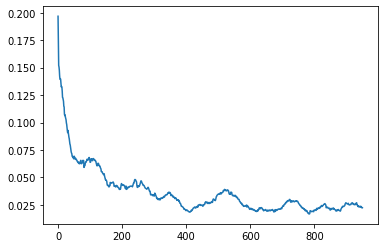

In [ ]:
kaggle_data = get_kaggle_data(augmentation=1)
resnet_swsl = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet18_swsl')
# Before
# resnet_swsl.fc = nn.Linear(512, 1000)
resnet_swsl.fc = nn.Linear(512, 2) # Reinitializes final layer, assigns random weights

resnet_swsl_losses = train(resnet_swsl, kaggle_data['train'], epochs=5, lr=.01, print_every=100)
plt.plot(smooth(resnet_swsl_losses,50))

## Comparing the Three Models


Testing using the 3 different model, getting the preditctions putting them in an array and exporting them into a .csv to be checked against Kaggles labels to get the accuracy of the model

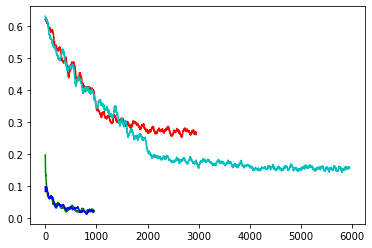

In [ ]:
plt.plot(smooth(darknet_losses,50), 'r-')
plt.plot(smooth(darknet_30_losses,50), 'c-')
plt.plot(smooth(resnet_losses,50),'g-')
plt.plot(smooth(resnet_swsl_losses,50),'b-')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
csv = '/content/drive/MyDrive/colab_files/final_proj/'
if not os.path.exists(csv):
    os.makedirs(csv)

Mounted at /content/drive


In [ ]:
darknet_results = accuracy(darknet, kaggle_data['test'])
darknet_results['results'] = darknet_results['results'].astype('uint8')
df_darknet = pd.DataFrame({'id': darknet_results['image_paths'], 'labels': darknet_results['results']})
df_darknet.to_csv(csv +'darknet_submission.csv', index=False)

darknet_30_results = accuracy(darknet_30, kaggle_data['test'])
darknet_30_results['results'] = darknet_30_results['results'].astype('uint8')
df_darknet_30 = pd.DataFrame({'id': darknet_30_results['image_paths'], 'labels': darknet_30_results['results']})
df_darknet_30.to_csv(csv +'darknet_30_submission.csv', index=False)

resnet_results = accuracy(resnet, kaggle_data['test'])
resnet_results['results'] = resnet_results['results'].astype('uint8')
df_resnet = pd.DataFrame({'id': resnet_results['image_paths'], 'labels': resnet_results['results']})
df_resnet.to_csv(csv + 'resnet_submission.csv', index=False)

resnet_swsl_results = accuracy(resnet_swsl, kaggle_data['test'])
resnet_swsl_results['results'] = resnet_swsl_results['results'].astype('uint8')
df_resnet_swsl = pd.DataFrame({'id': resnet_swsl_results['image_paths'], 'labels': resnet_swsl_results['results']})
df_resnet_swsl.to_csv(csv + 'resnet_swsl_submission.csv', index=False)